In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

**Key Assumptions:**
* Event date is weekday
* There were no prior response events or major Holidays
* Using the Weather-Sensitive CBL option
* 2PM - 6PM EDT is inclusive of 6 PM

### Define Calculations

In [217]:
def clean_dataset(csv):
    
    ## First, ingest the CSV for each business
    print('Resource:', csv)
    
    df = pd.read_csv(csv)
    df.rename(columns={"HE (EST)": "time_est","kWH":"kwh"}, inplace=True)
    
    ## Create a datetimeindex dataframe for ease of use with time series work
    df.index = pd.DatetimeIndex(df.time_est, copy=False)
    df.drop(columns='time_est', inplace=True)
    
    ## Print subset of results for QA
    print("CSV has %s rows and %s column(s)" %(df.shape[0], df.shape[1]))
    
    return df
    

In [218]:
def calculate_cbl(data, event_date, event_start_hr, event_end_hr):
    
    event_hrs = list(range(event_start_hr, event_end_hr+1))
    adjustment_period_hrs = list(range(event_start_hr-4, event_start_hr-2))
    
    print('Event Hours:', event_hrs)
    print('Adjustment Hours:', adjustment_period_hrs)
    
    ## Round each 15 minute interval down to its hour 
    data.index = data.index.floor('H')
    data = data.groupby(data.index)['kwh'].sum().reset_index()
    
    ## Reset datetimeindex
    data.index = pd.DatetimeIndex(data.time_est, copy=False)
    data.drop(columns='time_est', inplace=True)
    
    ## Calculate 30 day window
    period_start = df.loc[event_date][:1].index - datetime.timedelta(30)
    
    ## Spotcheck dates
    print("Event date:",event_date)
    print("30 days prior date:",period_start[0].date())
    
    ## Filter down to 30 day window
    subset_1 = data.loc[str(period_start[0].date()):str(event_date)]
    
    ## Create hour field for event start and end hour filtering
    subset_1['hour'] = subset_1.index.hour
    
    ## Filter down to hours of event
    subset_2 = subset_1[subset_1.hour.isin(event_hrs)]
    
    ## Find peak usage hour within hours of event and calculate seed value
    peak_hour = subset_2[subset_2.kwh==subset_2.kwh.max()]
    seed_value = peak_hour.kwh * .25
    print('Seed value:', seed_value[0])
    
    ## Find Avg Daily Event Period Usage: simple average of actual usage for weekdays during hours of event
    ## Logic below to select weekdays only
    subset_3 = subset_2[subset_2.index.weekday.isin([0,1,2,3,4])]
    
    ## Group by date to get Average Daily Event Period Usage
    subset_4 = subset_3.groupby(subset_3.index.date)['kwh'].mean().reset_index()
    
    ## Eliminate low usage days, as defined by average daily usage below seed value
    subset_5 = subset_4[subset_4.kwh>=seed_value[0]]
    
    ## Next, rank to get top 5 by Average Daily Event Period Usage
    subset_6 = subset_5.sort_values(by='kwh', ascending=False)[:5]
    
    ## Reset data to datetimeindex
    subset_6.index = pd.DatetimeIndex(subset_6['index'], copy=False)
    subset_6.drop(columns='index', inplace=True)
    
    ## Revert to get hour granularity for the top 5 days
    subset_7 = pd.DataFrame()

    for date in subset_6.index.date:
        values = subset_3.loc[str(date)]
        subset_7 = pd.concat([subset_7,values])
    
    ## Calculate hourly Average Day CBL values for the event
    subset_8 = subset_7.groupby(by='hour')['kwh'].mean()
    
    #### Calculate Event Final Adjustment Factor #####
    subset_9 = pd.DataFrame()
    
    ## Get the hourly data for the 5 days selected for Average CBL Basis
    for date in subset_6.index.date:
        values = subset_1.loc[str(date)]
        subset_9 = pd.concat([subset_9,values])
    
    ## Apply Average Day CBL for adjusted hours
    subset_10 = subset_9[subset_9.hour.isin(adjustment_period_hrs)]
    
    ## Calculate Adjustment Basis Average CVL, as defined by average of the average of both adjusted hours
    adjust_basis_avg_cbl = subset_10.groupby(by='hour')['kwh'].mean().mean()
    
    ## Adjustment Basis Average Load is simple average of resource's load on event day for adjusted hours
    subset_11 = data.loc[event_date][data.loc[event_date].index.hour.isin(adjustment_period_hrs)]
    adjust_basis_avg_load = subset_11['kwh'].mean()
    
    ## Find Gross Adjustment Factor = Adjustment Basis Average Load / Adjustment Basis Average CBL
    gross_adjust_factor = adjust_basis_avg_load / adjust_basis_avg_cbl
    
    ## Determine Final Adjustment Factor
    if gross_adjust_factor > 1.00:
        final_adjust_factor = min(gross_adjust_factor, 1.20)
    elif gross_adjust_factor < 1.00:
        final_adjust_factor = max(gross_adjust_factor, 0.80)
    else:
        final_adjust_factor = gross_adjust_factor
    
    print('Final Adjustment Factor: ', final_adjust_factor)
    
    ## Calculate the Adjusted CBL values
    adjusted_cbl_values = final_adjust_factor * subset_8
    
    ## Print Results
    impact = adjusted_cbl_values - subset_1.loc['2017-06-13 14:00:00':'2017-06-13 18:00:00']['kwh'].values
    print('Customer impact after subtracting weather-sensitive CBL:\n', impact)
    print('\n')
    
#     return adjusted_cbl_values, subset_1.loc['2017-06-13 14:00:00':'2017-06-13 18:00:00']

### Run Calculations for All Resources

In [219]:
date = '2017-06-13'
start_hour = 14
end_hour = 18

calculate_cbl(clean_dataset('site_1.csv'), date, start_hour, end_hour)
calculate_cbl(clean_dataset('site_2.csv'), date, start_hour, end_hour)
calculate_cbl(clean_dataset('site_3.csv'), date, start_hour, end_hour)
calculate_cbl(clean_dataset('site_5.csv'), date, start_hour, end_hour)
calculate_cbl(clean_dataset('site_6.csv'), date, start_hour, end_hour)

Resource: site_1.csv
CSV has 4896 rows and 1 column(s)
Event Hours: [14, 15, 16, 17, 18]
Adjustment Hours: [10, 11]
Event date: 2017-06-13
30 days prior date: 2017-05-14
Seed value: 5254.2
Final Adjustment Factor:  1.009071204945011
Customer impact after subtracting weather-sensitive CBL:
 hour
14     8833.826925
15     6219.489990
16     7589.205170
17    -4965.445003
18    11726.613470
Name: kwh, dtype: float64


Resource: site_2.csv
CSV has 4896 rows and 1 column(s)
Event Hours: [14, 15, 16, 17, 18]
Adjustment Hours: [10, 11]
Event date: 2017-06-13
30 days prior date: 2017-05-14
Seed value: 1292.4
Final Adjustment Factor:  1.0891709763359976
Customer impact after subtracting weather-sensitive CBL:
 hour
14    5169.805924
15    5020.522990
16    4962.776305
17    2962.712553
18     705.333709
Name: kwh, dtype: float64


Resource: site_3.csv
CSV has 4896 rows and 1 column(s)
Event Hours: [14, 15, 16, 17, 18]
Adjustment Hours: [10, 11]


/Users/johnsylvester1/anaconda2/envs/newvenv/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Event date: 2017-06-13
30 days prior date: 2017-05-14
Seed value: 230.94
Final Adjustment Factor:  1.0550849261419268
Customer impact after subtracting weather-sensitive CBL:
 hour
14    915.695546
15    908.858596
16    856.669875
17    326.359363
18    137.598234
Name: kwh, dtype: float64


Resource: site_5.csv
CSV has 4896 rows and 1 column(s)
Event Hours: [14, 15, 16, 17, 18]
Adjustment Hours: [10, 11]
Event date: 2017-06-13
30 days prior date: 2017-05-14
Seed value: 2517.87
Final Adjustment Factor:  0.8
Customer impact after subtracting weather-sensitive CBL:
 hour
14    2085.7680
15    1494.6672
16    2019.2736
17     770.4576
18   -1673.6400
Name: kwh, dtype: float64


Resource: site_6.csv
CSV has 4896 rows and 1 column(s)
Event Hours: [14, 15, 16, 17, 18]
Adjustment Hours: [10, 11]
Event date: 2017-06-13
30 days prior date: 2017-05-14
Seed value: 93.15
Final Adjustment Factor:  1.2
Customer impact after subtracting weather-sensitive CBL:
 hour
14     69.7824
15    116.2296
16  

### Visualize Impact of Individual Resource - Site 2

In [186]:
cbl, event_data = calculate_cbl(clean_dataset('site_2.csv'), date, start_hour, end_hour)


Resource: site_2.csv
CSV has 4896 rows and 1 column(s)
Event Hours: [14, 15, 16, 17, 18]
Adjustment Hours: [10, 11]
Event date: 2017-06-13
30 days prior date: 2017-05-14
Seed value: 1292.4
Final Adjustment Factor:  1.0891709763359976
Customer impact after subtracting weather-sensitive CBL:
 hour
14    5169.805924
15    5020.522990
16    4962.776305
17    2962.712553
18     705.333709
Name: kwh, dtype: float64




/Users/johnsylvester1/anaconda2/envs/newvenv/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [187]:
cbl = cbl.reset_index()

In [188]:
cbl

,hour,kwh
0,14,5490.205924
1,15,5355.322990
2,16,5283.176305
3,17,5345.912553
4,18,5334.933709


In [193]:
event_data.index = event_data.hour
event_data.drop(columns='hour', inplace=True)

In [194]:
event_data

,kwh
hour,
14,320.4
15,334.8
16,320.4
17,2383.2
18,4629.6


In [213]:
joined = cbl.join(other=event_data, on='hour', lsuffix='_cbl',rsuffix='_res_usage')

In [214]:
joined

,hour,kwh_cbl,kwh_res_usage
0,14,5490.205924,320.4
1,15,5355.322990,334.8
2,16,5283.176305,320.4
3,17,5345.912553,2383.2
4,18,5334.933709,4629.6


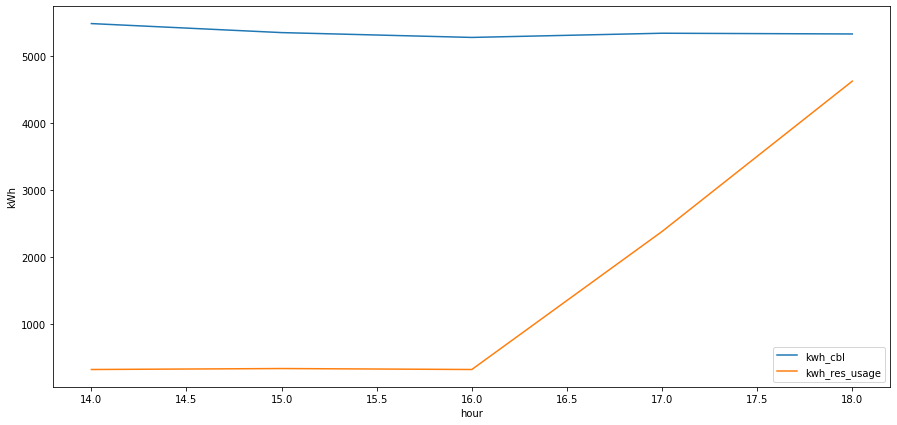

In [215]:
joined.plot(x='hour', y=['kwh_cbl','kwh_res_usage'], figsize=(15,7))
plt.ylabel('kWh')
plt.show()